# Shazam Audio Search

In this homework you will implement a Shazam audio search engine.  

I have provided a skeleton of the code below, and you will fill in any sections marked with `### START CODE BLOCK ###` and `### END CODE BLOCK ###`.  Please do not change the code outside of these markers.  In particular, do not define any new functions, change the code decomposition, or modify function inputs, outputs, or default values.  Note that this code is written for ease of understanding and ease of grading, not for efficiency.

I have provided sample outputs for you to verify when your function is implemented correctly.  Once you have completed this assignment, please run your notebook from beginning to end, make sure all outputs and plots are showing in the notebook, save your notebook, and then submit on Gradescope.  Also, make sure to include both partners' names at the top of your notebook.

Partner 1 Name: Diego Weiss

Number of hours spent (Partner 1): 5

Partner 2 Name: Jasper Cox

Number of hours spent (Partner 2): 5

In [104]:
%matplotlib inline

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.signal import stft
import glob
import subprocess
import os.path
import pickle
from collections import defaultdict
#import hw3_solns

### Step 1: Extract fingerprints (40 points)

The first step is to create a function that can extract fingerprints from an audio file.  

In [106]:
def extractFingerprints(mp3file, sr = 22050, winsz = 2048, hop = 512, regionH = 128, regionW = 40, maxDiffFrms = 120, timeDiffQuant = 2):
    """
    Extract fingerprints from an audio file.

    Arguments:
    
    mp3file -- string specifying the full path of the mp3 file
    sr -- desired sampling rate
    winsz -- size of the STFT analysis window in samples
    hop -- hop size of STFT in samples
    regionH -- height of the rectangular region used to select maxima
    regionW -- width of the rectangular region used to select maxima
    maxDiffFrms -- maximum allowable time difference (in frames) between peaks in a pair
    timeDiffQuant -- quantization factor applied to time differences between pairs of peaks
    
    Returns:
    
    result -- a list of (m,fp) tuples where fp is the fingerprint value (an integer) and m is the frame index
    specifying when the fingerprint occurs in time.  The list of tuples is non-decreasing in m.
    """
    # You don't need to change anything here, you'll modify the below functions.
    peaks = getSpectralPeaks(mp3file, sr, winsz, hop, regionH, regionW)
    pairs = getPeakPairs(peaks, maxDiffFrms)
    result = calculateFingerprints(peaks, pairs, timeDiffQuant)
    return result

In the getSpectralPeaks function, you should
- calculate the one-sided STFT
- divide the STFT into rectangular neighborhood regions (you may ignore fragments at the edges)
- determine the location of the spectral maximum in each neighborhood region
- filter out any neighborhood maxima that are not local maxima (i.e. the maximum of the neighborhood region centered around the peak)
- sort the peaks by time in non-decreasing order

This function uses `getMaxIndex` and `isLocalMax`.

Hint: It can be confusing to think about which indices correspond to what in `S`. Remember that rows are the y coordinates and columns are the x coordinates.

In [107]:
def getSpectralPeaks(mp3file, sr = 22050, winsz = 2048, hop = 512, regionH = 128, regionW = 40):    
    """
    Determine the locations in time and frequency of spectral peaks in the spectrogram.
    
    Arguments:
    mp3file -- string specifying the full path of the mp3 file
    sr -- the desired sampling rate
    winsz -- size of the STFT analysis window in samples
    hop -- hop size of STFT in samples
    regionH -- height of the rectangular region used to select maxima
    regionW -- width of the rectangular region used to select maxima
    
    Returns:
    peaks_sorted -- a list of (m, k) tuples where m specifies the frame offset of the peak and
       k specifies the frequency bin of the peak.  The tuples are sorted by m in non-decreasing order.
    """

    Y, sr  = lb.core.load(mp3file, sr = sr)
    f, t, S = stft(Y, fs = sr, nperseg = winsz, noverlap = winsz - hop)
    Smag = np.abs(S)
    height, width = S.shape
    peaks = []

    ### START CODE BLOCK ###

    for x in range(0, width-regionW+1, regionW):
        for y in range(0, height-regionH+1, regionH):
            region = Smag[y:y+regionH,x:x+regionW] 
            (m, k) = getMaxIndex(region, y, x)
            if isLocalMax(k, m, Smag, regionH, regionW):
                peaks.append((m, k))
                          # hint: you can do it in one line!
    peaks_sorted = sorted(peaks, key=lambda p: p[0]) # sort by m

    return peaks_sorted

In the getMaxIndex function, you should
* Find the index of the maximum in `region`
* Translate this index to the absolute indexing using `x` and `y`

Be careful here about how you use the indices of `region`: in our indexing scheme, the point (i,j) is found at `region[j][i]`.

This function is called by `getSpectralPeaks`.

Hint: If you find the appropriate numpy functions, you can write this in only a few lines. The function `numpy.unravel_index()` is useful here.

In [108]:
def getMaxIndex(region, row, col):
    """
    Determine the index of the maximum of a region and translate it back to the original coordinate scheme.
    
    Arguments:
    region -- a matrix to find the maximum of
    row -- the absolute row number of the bottom left corner of 'region'
    col -- the absolute col number of the bottom left corner of 'region'
    
    Returns:
    m -- the absolute column of the max
    k -- the absolute row of the max
    """
    
    ### START CODE BLOCK ###

    if region.size == 0:
        raise ValueError("getMaxIndex: empty region has no maximum")

    # Flatten argmax and convert back to (row_in_region, col_in_region)
    flat_index = np.argmax(region)
    r, c = np.unravel_index(flat_index, region.shape)

    m = col + c  # absolute column (time frame)
    k = row + r  # absolute row (frequency bin)
    return m, k

In the isLocalMax function, you should:
- determine the rectangular neighborhood region centered around the specified (row,col) element of matrix S (note that at the edges of S, this region may not be fully centered around the element)
- return True if the specified element is the maximum of this centered neighborhood region

This function is called by getSpectralPeaks()

Hint: You need to "clamp" the region around (row, col) if it exceeds the boundaries of `S`. Python built-in functions will be helpful here. Consider using `max`, for example.

In [109]:
def isLocalMax(row, col, S, regionH, regionW):
    '''
    Return true if the specified element in S is the maximum of a rectangular region centered around it.
    This is a helper function used to filter out neighborhood peaks that are not true local maxima.
    
    Arguments:
    
    row -- the row of the specified element
    col -- the column of the specified element
    S -- the matrix
    regionH -- the height of the rectangular region in rows
    regionW -- the width of the rectangular region in columns
    
    Returns:
    
    A boolean indicating if the specified element is the local maximum of a rectangular region centered
    around it.  The rectangular region extends from from rows [row - regionH/2, row + regionH/2) and
    columns [col - regionW/2, col + regionW/2).
    '''

    ### START CODE BLOCK ###
    # check if we need to clamp the region
    rows = S.shape[0]
    cols = S.shape[1]
    halfH_left  = regionH // 2
    halfH_right = regionH - halfH_left
    halfW_left  = regionW // 2
    halfW_right = regionW - halfW_left

    top    = max(0, row - halfH_left)
    bottom = min(rows, row + halfH_right)
    left   = max(0, col - halfW_left)
    right  = min(cols, col + halfW_right)

    region = S[top:bottom, left:right]
    if region.size == 0:
        return False

    
    # First check value-based maximality.
    center_val = S[row, col]
    region_max = np.max(region)
    if np.isnan(center_val) or center_val != region_max:
        return False


    m, k = getMaxIndex(region, top, left)
    isMax = (m, k) == (col, row)
    ### END CODE BLOCK ###

    return isMax

In the getPeakPairs function, you should:
- iterate through the sorted list of peaks
- find all pairs of peaks that have a time difference <= maxDiff
- construct a list of tuples (i,j) containing the peak pair indices where i < j

In [110]:
def getPeakPairs(peaks, maxDiff):
    """
    Return a list of all peak pairs that satisfy the maximum time difference condition.
    
    Arguments:
    peaks -- a list of (m,k) tuples specifying the frame offset and frequency bin of peaks.  The peaks
       are sorted in m in non-decreasing order.
    maxDiff -- the maximum allowable time difference between peaks in a pair
    
    Returns:
    pairs -- a list of (i,j) tuples specifying the indices of peak pairs, where i and j refer to indices
       in the given list of peaks.  This list of tuples should be non-decreasing in i.
    """
    pairs = []
    
    ### START CODE BLOCK ###
    i = 0
    j = 1
    n = len(peaks)
    for i in range(0, n-1):
        for j in range(i+1, n):
            if peaks[j][0] - peaks[i][0] <= maxDiff:
                pairs.append((i,j))
            
    ### END CODE BLOCK ###
    
    return pairs

In the calculateFingerprints function, you should:
- iterate through the peak pairs
- compute the fingerprint integer value for each peak pair
- store the fingerprint integer value and time offset in a list

Note that this function should call the packIntoInt() function.

In [111]:
def calculateFingerprints(peaks, pairs, timeDiffQuant):
    """
    Calculate a list of fingerprints on a set of peak pairs.
    
    Arguments:
    peaks -- a list of (m,k) tuples specifying the frame offset and frequency bin of peaks.  The peaks
       are sorted in m in non-decreasing order.
    pairs -- a list of (i,j) tuples specifying the indices of peak pairs.  This list of tuples is
       non-decreasing in i.
    timeDiffQuant -- quantization factor applied to time differences between pairs of peaks
       
    Returns:
    result -- a list of (m, fp) tuples where m specifies the frame offset of the fingerprint (i.e. the
       anchor peak) and fp specifies the fingerprint value (integer)
    """
    result = []

    ### START CODE BLOCK ###
    # get m out of peaks
    for pair in pairs:
        peak1 = peaks[pair[0]]
        peak2 = peaks[pair[1]]
        peak1_freq = peak1[1]
        peak2_freq = peak2[1]
        time_diff = peak2[0]-peak1[0]
        fp = packIntoInt(peak1_freq, peak2_freq, time_diff, timeDiffQuant)
        result.append((peak1[0],fp))
        
    ### END CODE BLOCK ###

    return result

In the packIntoInt function, you should:
- store f1 in the first 10 bits
- store f2 in the next 10 bits
- store the quantized time difference in the remaining bits

Note that you can shift an integer to the left by n bits by multiplying it by 2^n.

In [112]:
def packIntoInt(f1, f2, timediff, quant_factor):
    """
    Calculate the fingerprint value of a peak pair and package into a single integer value.
    
    Arguments:
    f1 -- frequency bin of anchor peak
    f2 -- frequency bin of non-anchor peak
    timediff -- time difference between peaks (in frames)
    quant_factor -- quantization factor applied to the time difference
    
    Returns:
    fp -- a single integer that specifies the fingerprint value, where the first 10 bits specify
       f1, the next 10 bits specify f2, and the remaining bits specify the quantized time difference.
    """
    
    ### START CODE BLOCK ###
    fp = int(f1) | (int(f2) << 10) | (int(timediff/quant_factor) << 20)
    ### END CODE BLOCK ###

    return fp

Below I have included some sample outputs for you to verify that your implementation is correct.

In [113]:
a = np.zeros((4,5))
a[2,4] = 1
getMaxIndex(a, 10, 20)

(np.int64(24), np.int64(12))

(24, 12)

In [114]:
peaks = getSpectralPeaks('refs/005936.mp3')
peaks[0:5], len(peaks)

([(np.int64(3), np.int64(574)),
  (np.int64(3), np.int64(944)),
  (np.int64(11), np.int64(850)),
  (np.int64(64), np.int64(24)),
  (np.int64(86), np.int64(507))],
 97)

([(3, 574), (3, 944), (11, 850), (64, 24), (86, 507)], 97)

In [115]:
pairs = getPeakPairs(peaks, 120)
pairs[0:10], len(pairs)

([(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (1, 2),
  (1, 3),
  (1, 4),
  (1, 5)],
 825)

([(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (1, 2),
  (1, 3),
  (1, 4),
  (1, 5)],
 825)

In [116]:
packIntoInt(34, 240, 73, 2)

37994530

37994530

In [117]:
fps = calculateFingerprints(peaks, pairs, 2)
fps[0:8], len(fps)

([(np.int64(3), 967230),
  (np.int64(3), 5065278),
  (np.int64(3), 31482430),
  (np.int64(3), 43511358),
  (np.int64(3), 43790910),
  (np.int64(3), 50347582),
  (np.int64(3), 5065648),
  (np.int64(3), 31482800)],
 825)

([(3, 967230),
  (3, 5065278),
  (3, 31482430),
  (3, 43511358),
  (3, 43790910),
  (3, 50347582),
  (3, 5065648),
  (3, 31482800)],
 825)

In [118]:
fps = extractFingerprints('refs/005936.mp3')
fps[0:8], len(fps)

([(np.int64(3), 967230),
  (np.int64(3), 5065278),
  (np.int64(3), 31482430),
  (np.int64(3), 43511358),
  (np.int64(3), 43790910),
  (np.int64(3), 50347582),
  (np.int64(3), 5065648),
  (np.int64(3), 31482800)],
 825)

([(3, 967230),
  (3, 5065278),
  (3, 31482430),
  (3, 43511358),
  (3, 43790910),
  (3, 50347582),
  (3, 5065648),
  (3, 31482800)],
 825)

### Construct database (10 points)

Now we will construct our database of fingerprints.

In the constructDatabase function, you will:
- iterate through all mp3 files in the directory (hint: use `glob`)
- extract a list of fingerprints from each file
- store the fingerprint information in the dictionary d as an inverted index

Note that this function should call the extractFingerprints() function.

In [119]:
def constructDatabase(indir):
    """
    Construct a database of fingerprints for all mp3 files in the specified directory.
    
    Arguments:
    indir -- directory containing mp3 files
    
    Returns:
    d -- database of fingerprints in the form a python dictionary, where the key is the fingerprint (integer)
        and the value is a list of (song, m) tuples specifying the name of the mp3 file (basename only) and
        the time offset in frames where the matching fingerprint occurs.
    """
    # a defaultdict is like a python dictionary, but if you have some 'key' that isn't in 'd',
    # 'd[key]' is initialized to a default value (in this case the empty list). This means it's
    # always safe to do 'd[key].append(value)'.
    d = defaultdict(list)

    ### START CODE BLOCK ###
    mp3_files = glob.glob('*.mp3',root_dir=indir)
    for rel_name in mp3_files:
        full_path = os.path.join(indir, rel_name)
        song = os.path.basename(rel_name)

        # Assumes extractFingerprints returns iterable of (m, fp)
        for (m, fp) in extractFingerprints(full_path):
            d[int(fp)].append((song, int(m)))
    ### END CODE BLOCK ###

    return d

In [120]:
ref_dir = 'refs/'
db = constructDatabase(ref_dir) # note that this may take a minute or so to run

Let's save the database to file for convenient access later.

In [121]:
with open('db.pkl','wb') as f:
    pickle.dump(db, f)

In [122]:
with open('db.pkl','rb') as f:
    db = pickle.load(f)

### Search (30 points)

Now we will process the audio queries in the queries/ folder.  These are random 10 second segments extracted from the reference tracks.

In the getMatchScore function, you will:
- get a list of scatterpoints and offsets for matching fingerprints by calling the `getOffsets` function
- convert the list of scatterpoints and offsets to numpy arrays
- compute a histogram of offsets with bin width 1.  The function `numpy.histogram` may be useful.
- calculate the match score as the maximum histogram count

Hint: Make sure your function handles the case when there are no matching fingerprints at all!

In [123]:
def getMatchScore(query_fps, db, songid, visualize = False):
    """
    Determine the match score between a set of query fingerprints and a single song in the database.
    
    Arguments:
    query_fps -- a list of tuples (m, fp) specifying the time offset (in frames) and value of 
       fingerprints extracted from an audio query
    db -- database of fingerprints
    songid -- the song of interest, specified as a filename (e.g. '005936.mp3')
    visualize -- if True, show a plot containing (a) a scatterplot of matching fingerprints for the
       given song, and (b) a histogram of offsets for matching fingerprints for the given song.
    
    Returns:
    matchScore -- a scalar indicating how well the query matches this song in the database
    """

    ### START CODE BLOCK ###        
    points, offsets = getOffsets(query_fps, db, songid)
    offset_count = len(offsets)
    
    if len(points) == 0:
        #print('No matching fingerprints')
        return 0

    bins = np.arange(min(offsets), max(offsets) + 2, 1)
    counts, bin_edges = np.histogram(offsets, bins=bins)
    matchScore = max(counts)

    
    ### END CODE BLOCK ###
    
    if visualize:
        if len(points) == 0:
            #print('No matching fingerprints')
            pass
        else:
            plt.subplot(121)
            xs, ys = zip(*points)
            plt.plot(xs, ys, 'o')
            plt.title('Matching Fingerprints')
            plt.xlabel('Ref Time (frames)')
            plt.ylabel('Query Time (frames)')
            plt.subplot(122)
            plt.hist(offsets, bins=np.arange(min(offsets), max(offsets)+2,1))
            plt.show()
    
    return matchScore

In the `getOffsets` function, you will:
- iterate through the query fingerprints
- retrieve all matching fingerprints from the inverted index
- filter out any matching fingerprints from songs other than the one specified in songid
- create a list of (ref_offset, query_offset) tuples for matching fingerprints in songid
- return that list, as well as a list containing the (ref_offset - query_offset) differences

In [124]:
def getOffsets(query_fps, db, songid):
    """
    Find the offsets of matching fingerprints between a query and a database.
    
    Arguments:
    query_fps -- a list of tuples (m, fp) specifying the time offset (in frames) and value of 
       fingerprints extracted from an audio query
    db -- database of fingerprints
    songid -- the song of interest, specified as a filename (e.g. '005936.mp3')
    
    Returns:
    points -- a list of (ref_offset, query_offset) tuples
    offsets -- a list of (ref_offset - query_offset) values
    """
    
    points = []
    #db structure
    # key: fingerprint
    # value: (song_id, frame offset)
    ### START CODE BLOCK ###
    offsets = []
    for query_offset, fp in query_fps:
        # (frame offset, fingerprint)
        matches = db[fp]
        for match_song_id, ref_offset in matches:
            # check if song id matches
            if match_song_id == songid:
                points.append((ref_offset, query_offset))
                offsets.append(ref_offset - query_offset)
    ### END CODE BLOCK ###
    
    return points, offsets

In the findBestMatch function, you will:
- extract fingerprints from the specified query file
- iterate through all of the songs in the database and calculate a match score on each
- sort the songs in decreasing order of match score
- if verbose = True, print out the top 5 match scores and song names
- determine the song with highest match score

Note that this function should call the extractFingerprints() and getMatchScore() functions.

In [125]:
def findBestMatch(query_file, db, ref_dir, verbose = False):
    """
    Return the name of the mp3 file that has the highest match score.
    
    Arguments:
    query_file -- string specifying the query audio file
    db -- database of fingerprints
    ref_dir -- directory containing all of the reference files in the database
    verbose -- whether or not to print out the top 5 matches (for debugging) 
    
    Returns:
    bestmatch -- a string containing the name of the mp3 file with highest match score
    """
    
    ### START CODE BLOCK ###
    bestMatch = None

    # call extractFingerprints
    query_fps = extractFingerprints(query_file)
    # extract all song names from reference directory
    mp3_files = glob.glob('*.mp3',root_dir=ref_dir)

    # pass those into getMatchScore along with query fingerprints
    match_scores = []
    for songid in mp3_files:
        # call getMatchScore
        match_score = getMatchScore(query_fps, db, songid)
        match_scores.append((songid, int(match_score)))
    
    match_scores_sorted = sorted(match_scores, key=lambda p: p[1], reverse=True)

    if verbose:
        print(match_scores_sorted[0:5])

    return match_scores_sorted[0][0]
    ### END CODE BLOCK ###
    
    return bestMatch

In the runBenchmark function, you will:
- iterate through all of the query files in the specified directory
- find the song with highest match score
- check if the predicted match is correct
- print out the accuracy across all queries

Note that this function should call the findBestMatch() function.

In [126]:
def runBenchmark(query_dir, ref_dir, db):
    """
    Run an entire benchmark and print out the accuracy of the system.
    
    Arguments:
    query_dir -- directory containing the query mp3 files
    ref_dir -- directory containing the reference mp3 files
    db -- database of fingerprints
    
    Returns:
    No return value.  Prints out the accuracy of the system.
    """

    ### START CODE BLOCK ###
    accuracy = 0
    
    query_files = glob.glob('*.mp3',root_dir=query_dir)
    #reference_files = glob.glob('*.mp3',root_dir=ref_dir)
    #print(query_files)
    for q in query_files:
        full_path = os.path.join(query_dir, q)
        song = os.path.basename(q)
        
        best_match = findBestMatch(full_path, db, ref_dir)
        if best_match == song:
            accuracy += 1
        else:
            print(f"No match. Query song: {song}. Best match: {best_match}")
    accuracy = accuracy / len(query_files)
    ### END CODE BLOCK ###

    
        

    print('Accuracy: %.2f %%' % (accuracy * 100.0))

Here are some sample outputs to verify that your implementation is correct.

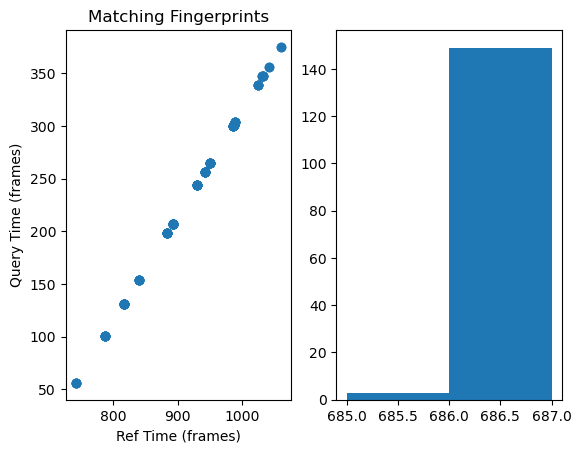

np.int64(149)

In [127]:
query_fps = extractFingerprints('queries/005936.mp3')
getMatchScore(query_fps, db, '005936.mp3', True)

149

<img src="figs/extractFingerprints.png">

In [128]:
getMatchScore(query_fps, db, '054156.mp3', True)

0

No matching fingerprints

0

In [129]:
findBestMatch('queries/120208.mp3', db, ref_dir, True)

[('120208.mp3', 226), ('113934.mp3', 1), ('066076.mp3', 1), ('148610.mp3', 0), ('054156.mp3', 0)]


'120208.mp3'

Top match scores
120208.mp3 226,
066076.mp3 1,
113934.mp3 1,
114065.mp3 0,
071372.mp3 0

'120208.mp3'

In [130]:
runBenchmark('queries', ref_dir, db)

Accuracy: 100.00 %


Accuracy: 100.00 %

### Test on class dataset (20 points)

Now we will run some experiments on real noisy data that our class will collect.

In this part, you will do the following:
- Each team will collect 3-4 cell phone recordings.  Please sign up for your 3-4 recordings in [this spreadsheet](https://docs.google.com/spreadsheets/d/1sWgcx3MTSReEbiXlMKtTMt2UMWoUZfEklN3ObKv1pB4/edit?usp=sharing).  For each recording, play the original audio recording from your laptop (or nicer speaker if you have one) and record approximately 10 seconds of the song on your cell phone.  Upload your recordings to this [shared google drive folder](https://drive.google.com/drive/folders/1oUyvgpeXzMLbwk-LSRp85F68l18Ydliq?usp=sharing), making sure to name them appropriately (they should have the same basename as the original audio recording).  Your cell phone recordings should be uploaded to the folder by Saturday noon (-5 points if not done by then) to ensure everyone has enough time to run experiments before the homework deadline.
- Once our class has finished collecting the audio data, download the audio data from the shared google drive folder and save it into your homework directory.
- Run a benchmark on the real noisy queries.  Describe how the system behaves with real noisy queries vs clean queries.  What are the weaknesses of the system?  Use plots, figures, and/or data to support your answer.
- Describe one way that you could improve the performance of the system on the real noisy queries.  Explain the tradeoffs (if any) of your proposal, describe the intuition for why it would improve performance, and provide plots, figures, and/or data to support your answer.

Please make sure to include both your comments (in markdown cells) and your code and visualizations.

In [131]:
### INSERT CODE AND MARKDOWN CELLS BELOW ###
runBenchmark('class_queries', ref_dir, db)

No match. Query song: 139536.mp3. Best match: 054719.mp3
No match. Query song: 066076.mp3. Best match: 115288.mp3
Accuracy: 93.33 %


Just looking at the benchmark, we can immediately determine that the performance of our system worsens slightly with noisy queries. 

In [132]:
findBestMatch('class_queries/038820.mp3', db, ref_dir, True)
findBestMatch('queries/038820.mp3', db, ref_dir, True)

[('038820.mp3', 33), ('148610.mp3', 0), ('054156.mp3', 0), ('057164.mp3', 0), ('139536.mp3', 0)]
[('038820.mp3', 151), ('148610.mp3', 0), ('054156.mp3', 0), ('057164.mp3', 0), ('139536.mp3', 0)]


'038820.mp3'

Comparing the output of findbestMatch on a noisy query and the original query, we see that the match score is significantly (5x) higher for the original query than the noisy query.

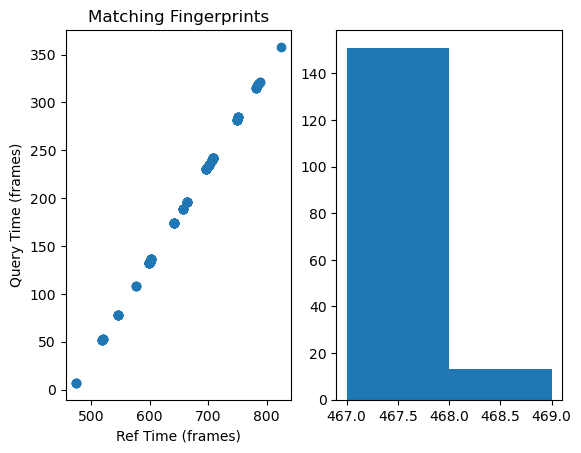

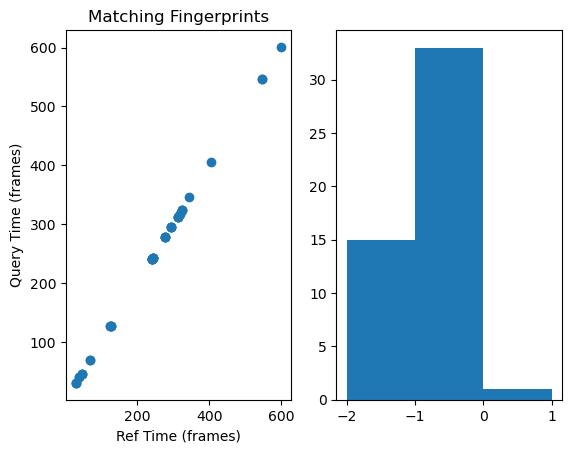

np.int64(33)

In [133]:
query_fps = extractFingerprints('queries/038820.mp3')
class_fps = extractFingerprints('class_queries/038820.mp3')
getMatchScore(query_fps, db, '038820.mp3', True)
getMatchScore(class_fps, db, '038820.mp3', True)

Looking at the histograms above, we can see that are multiple bins with relatively high matches. By increasing the bin size, we can potentially improve our recall for noisy or slightly drifted audio. This is because increasing bin size allows for a slight tempo variation when pairing matches together.

In [134]:
# helper function for bin width
def get_score(offsets, width):
    if not offsets: return 0
    # Create bins that step by 'width'
    bins = np.arange(min(offsets), max(offsets) + width + 1, step=width)
    counts, _ = np.histogram(offsets, bins=bins)
    return np.max(counts) if len(counts) > 0 else 0

Score (Width=1): 33
Score (Width=5): 49 (Improvement: +16)
Score (Width=1): 151
Score (Width=5): 164 (Improvement: +13)


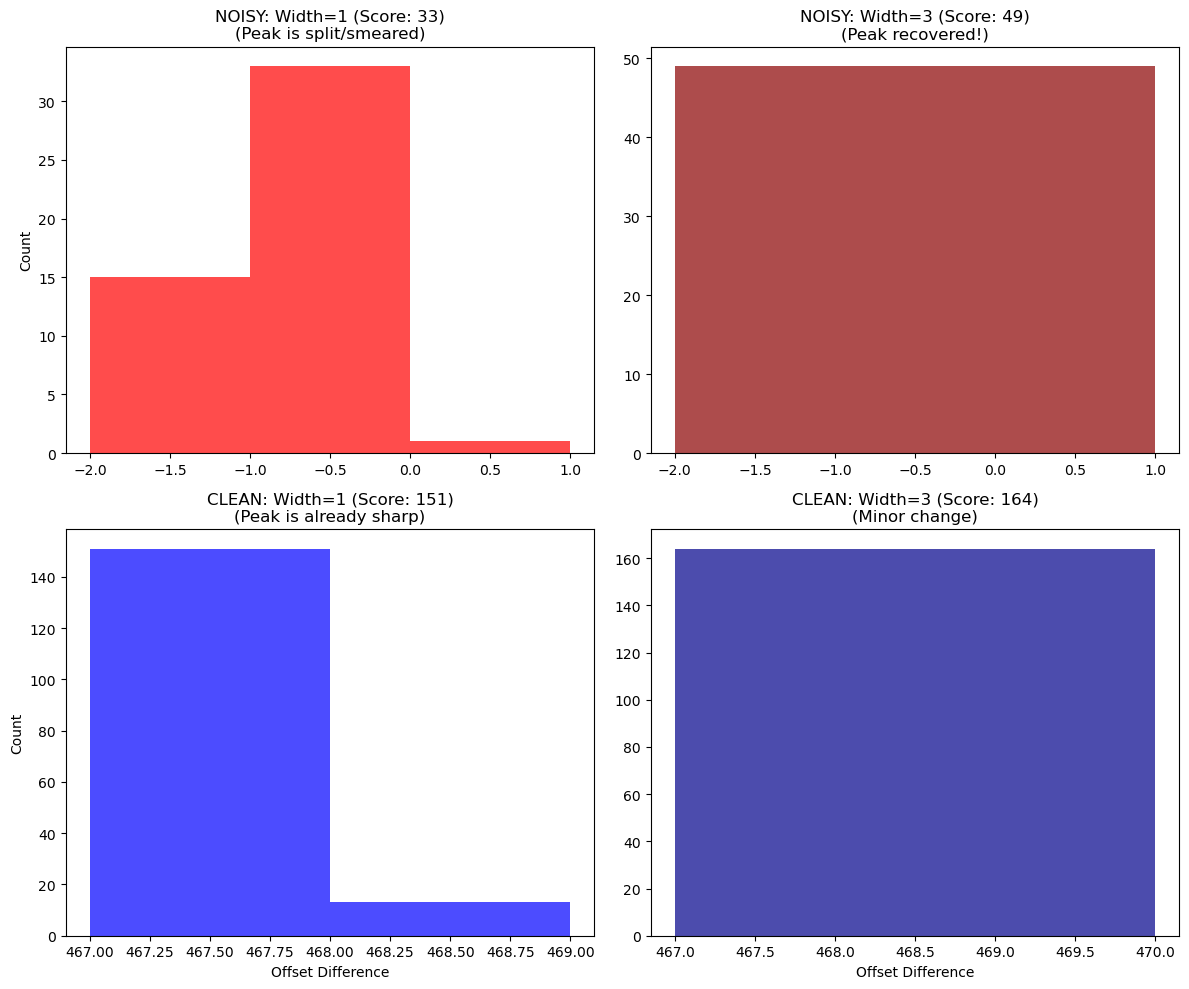

In [ ]:
noisy_file = 'class_queries/038820.mp3'
clean_file = 'queries/038820.mp3'
song_id = '038820.mp3'

# analyze noisy query
fps_noisy = extractFingerprints(noisy_file)
_, offsets_noisy = getOffsets(fps_noisy, db, song_id)

score_noisy_1 = get_score(offsets_noisy, width=1)
score_noisy_3 = get_score(offsets_noisy, width=3)

print(f"Score (Width=1): {score_noisy_1}")
print(f"Score (Width=3): {score_noisy_3} (Improvement: +{score_noisy_3 - score_noisy_1})")

# analyze reference
fps_clean = extractFingerprints(clean_file)
_, offsets_clean = getOffsets(fps_clean, db, song_id)

score_clean_1 = get_score(offsets_clean, width=1)
score_clean_3 = get_score(offsets_clean, width=3)

print(f"Score (Width=1): {score_clean_1}")
print(f"Score (Width=3): {score_clean_3} (Improvement: +{score_clean_3 - score_clean_1})")

plt.figure(figsize=(12, 10))

# Top Row: Noisy Query
plt.subplot(2, 2, 1)
plt.hist(offsets_noisy, bins=np.arange(min(offsets_noisy), max(offsets_noisy) + 2, 1), color='red', alpha=0.7)
plt.title(f"NOISY: Width=1 (Score: {score_noisy_1})\n(Peak is split/smeared)")
plt.ylabel("Count")

plt.subplot(2, 2, 2)
plt.hist(offsets_noisy, bins=np.arange(min(offsets_noisy), max(offsets_noisy) + 4, 3), color='darkred', alpha=0.7)
plt.title(f"NOISY: Width=3 (Score: {score_noisy_3})\n(Peak recovered!)")

# Bottom Row: Clean Query
plt.subplot(2, 2, 3)
plt.hist(offsets_clean, bins=np.arange(min(offsets_clean), max(offsets_clean) + 2, 1), color='blue', alpha=0.7)
plt.title(f"CLEAN: Width=1 (Score: {score_clean_1})\n(Peak is already sharp)")
plt.ylabel("Count")
plt.xlabel("Offset Difference")

plt.subplot(2, 2, 4)
plt.hist(offsets_clean, bins=np.arange(min(offsets_clean), max(offsets_clean) + 4, 3), color='darkblue', alpha=0.7)
plt.title(f"CLEAN: Width=3 (Score: {score_clean_3})\n(Minor change)")
plt.xlabel("Offset Difference")

plt.tight_layout()
plt.show()

For the selected files, we still get the right match. However, we can see how increasing the bin count increases the number of matching fingerprints.